<a href="https://colab.research.google.com/github/pipaber/UTEC_2025_IA_FUNDAMENTALS/blob/main/TAREA/TAREA_2/Flow_Shop_Hill_Climbing_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Iteration... 0


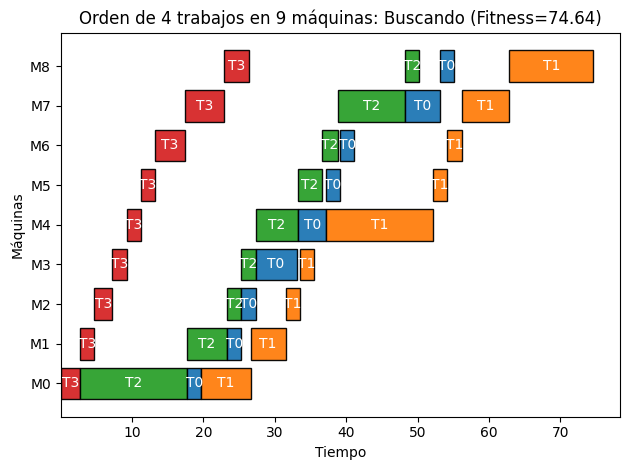

Current solution: [3 2 0 1] - Associated fitness: 60.52


Iteration... 1
Current solution: [3 1 0 2] - Associated fitness: 59.99


Iteration... 2
Current solution: [3 0 1 2] - Associated fitness: 59.99


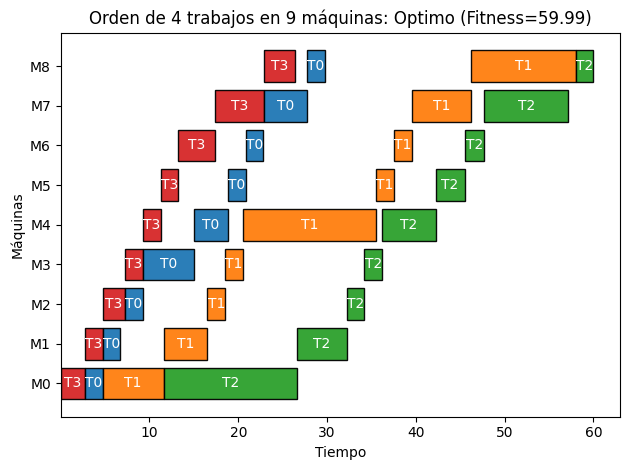

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros globales (predeterminados)
num_jobs = 4
num_machines = 9

# Paso 0: generación de la matriz de tiempos
def generar_matriz_aleatoria(
    num_filas, num_columnas,
    mean_time=4.0,
    minimo=2.0,
    maximo=15.0
):
    """
    Genera una matriz de tiempos de procesamiento aleatoria con distribución Exponencial
    recortada a [minimo, maximo].

    Parámetros:
    - num_filas: número de trabajos (filas).
    - num_columnas: número de máquinas (columnas).
    - mean_time: media de la Exponencial (1/λ).
    - minimo: tiempo mínimo permitido.
    - maximo: tiempo máximo permitido.
    """
    matriz_tiempos = np.random.exponential(scale=mean_time, size=(num_filas, num_columnas))
    np.clip(matriz_tiempos, minimo, maximo, out=matriz_tiempos)
    return matriz_tiempos

# Paso 1: cálculo de los tiempos de completado (DP)
def times_for_fitness(sol, tiempos_procesamiento):
    num_trabajos, num_maquinas = tiempos_procesamiento.shape
    matriz_tiempos = np.zeros((num_trabajos, num_maquinas), dtype=np.float32)
    for i, trabajo in enumerate(sol):
        for j in range(num_maquinas):
            if i == 0 and j == 0:
                matriz_tiempos[i, j] = tiempos_procesamiento[trabajo, j]
            elif i == 0:
                matriz_tiempos[i, j] = matriz_tiempos[i, j-1] + tiempos_procesamiento[trabajo, j]
            elif j == 0:
                matriz_tiempos[i, j] = matriz_tiempos[i-1, j] + tiempos_procesamiento[trabajo, j]
            else:
                matriz_tiempos[i, j] = max(
                    matriz_tiempos[i-1, j],
                    matriz_tiempos[i, j-1]
                ) + tiempos_procesamiento[trabajo, j]
    return matriz_tiempos

def fitness(sol, tiempos_procesamiento):
    """Makespan: tiempo de finalización del último trabajo en la última máquina."""
    return times_for_fitness(sol, tiempos_procesamiento)[-1, -1]

# Paso 2: generación de vecinos por swap
def get_neighbors(sol):
    neighbors = []
    for i in range(len(sol) - 1):
        for j in range(i + 1, len(sol)):
            new_sol = sol.copy()
            new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
            neighbors.append(new_sol)
    return neighbors

# Paso 3: visualización Gantt
def plot_schedule(sol, tiempos_procesamiento, fitness_val, tipo, alpha=0.95):
    matriz_tiempos = times_for_fitness(sol, tiempos_procesamiento)
    num_maquinas = tiempos_procesamiento.shape[1]
    fig, ax = plt.subplots()
    for i, trabajo in enumerate(sol):
        for j in range(num_maquinas):
            inicio = matriz_tiempos[i, j] - tiempos_procesamiento[trabajo, j]
            duracion = tiempos_procesamiento[trabajo, j]
            ax.barh(y=j, width=duracion, left=inicio,
                    color=f"C{trabajo}", edgecolor="black", alpha=alpha)
            ax.text(inicio + duracion/2, j, f"T{trabajo}",
                    va="center", ha="center", color="white")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Máquinas")
    ax.set_title(f"Orden de {len(sol)} trabajos en {num_maquinas} máquinas: {tipo} (Fitness={fitness_val:.2f})")
    ax.set_yticks(range(num_maquinas))
    ax.set_yticklabels([f"M{j}" for j in range(num_maquinas)])
    plt.tight_layout()
    plt.show()

# Paso 4: hill-climbing con conteo de iteraciones
def hill_climbing(current_solution, tiempos_procesamiento, plot_interval=4):
    print()
    count = 0
    best_fitness = fitness(current_solution, tiempos_procesamiento)
    while True:
        print(f"Iteration... {count}")
        neighbors = get_neighbors(current_solution)
        best_neighbor = min(neighbors, key=lambda s: fitness(s, tiempos_procesamiento))
        best_neighbor_fitness = fitness(best_neighbor, tiempos_procesamiento)
        if count % plot_interval == 0:
            plot_schedule(
                current_solution,
                tiempos_procesamiento,
                fitness(current_solution, tiempos_procesamiento),
                "Buscando"
            )
        print(
            f"Current solution: {current_solution} - "
            f"Associated fitness: {best_neighbor_fitness:.2f}"
        )
        if best_neighbor_fitness < fitness(current_solution, tiempos_procesamiento):
            current_solution = best_neighbor
            best_fitness = best_neighbor_fitness
        else:
            return current_solution, best_fitness
        print()
        count += 1
        print()

sol_opt, fit_opt = hill_climbing(
        current_solution, tiempos_procesamiento
    )
plot_schedule(sol_opt, tiempos_procesamiento, fit_opt, "Optimo")



In [69]:
def run_flowshop_hill_climbing(
    num_jobs, num_machines,
    mean_time=4.0, minimo=2.0, maximo=15.0,
    plot_interval=4, seed=None
):
    """
    Ejecuta hill-climbing para un flow-shop con num_jobs y num_machines.
    Retorna la solución óptima encontrada y su makespan.
    """
    if seed is not None:
        np.random.seed(seed)
    tiempos_procesamiento = generar_matriz_aleatoria(
        num_jobs, num_machines, mean_time, minimo, maximo
    )
    print("Trabajos vs Máquinas = Tiempos")
    print(tiempos_procesamiento)
    sol0 = np.arange(num_jobs)
    np.random.shuffle(sol0)
    print("\nSolución Inicial:", sol0)
    print(f"Fitness Inicial: {fitness(sol0, tiempos_procesamiento):.2f}\n")
    sol_opt, fit_opt = hill_climbing(sol0, tiempos_procesamiento, plot_interval)
    print(f"\nSolución Óptima: {sol_opt}")
    print(f"Fitness Óptimo: {fit_opt:.2f}")
    plot_schedule(sol_opt, tiempos_procesamiento, fit_opt, "Optimo")
    return sol_opt, fit_opt

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]]

Solución Inicial: [3 5 0 2 1 4]
Fitness Inicial: 76.10


Iteration... 0


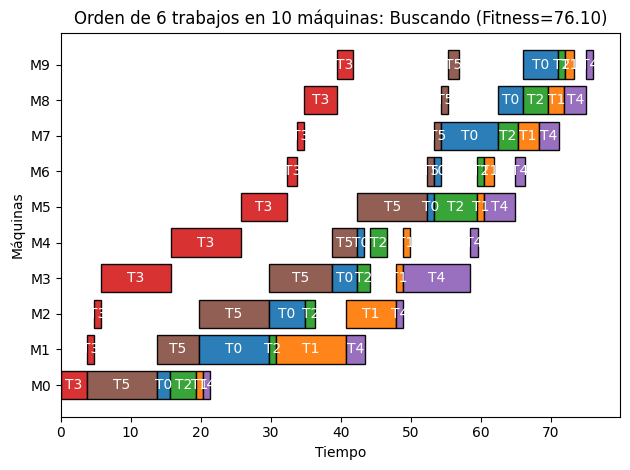

Current solution: [3 5 0 2 1 4] - Associated fitness: 71.97


Iteration... 1
Current solution: [3 2 0 5 1 4] - Associated fitness: 71.73


Iteration... 2


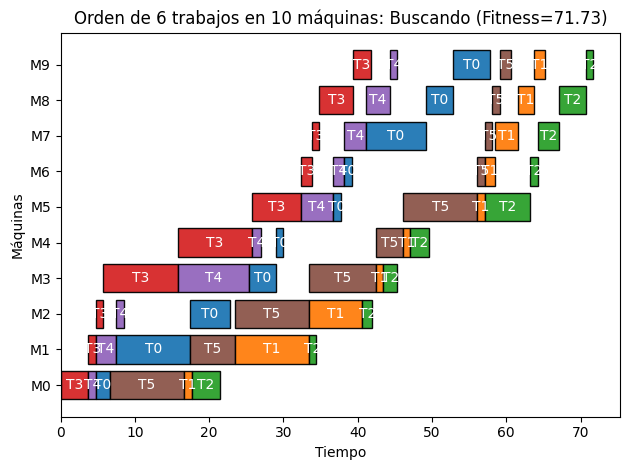

Current solution: [3 4 0 5 1 2] - Associated fitness: 70.87


Iteration... 3
Current solution: [4 3 0 5 1 2] - Associated fitness: 71.73

Solución Óptima: [4 3 0 5 1 2]
Fitness Óptimo: 70.87


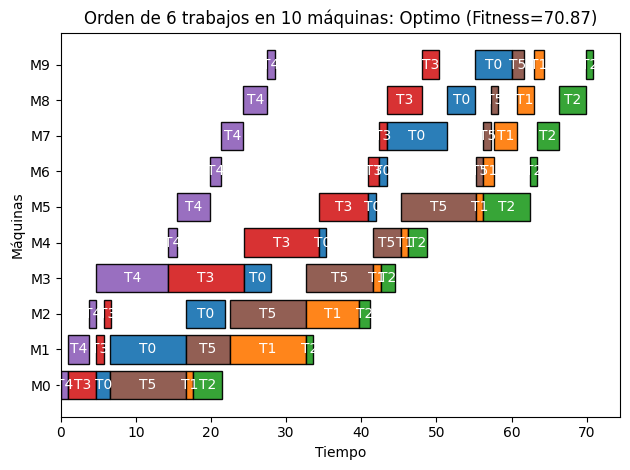

(array([4, 3, 0, 5, 1, 2]), np.float32(70.870094))

In [70]:
run_flowshop_hill_climbing(
            num_jobs=6,
            num_machines=number_of_machines,
            mean_time=4.0,
            minimo=1.0,
            maximo=10.0,
            plot_interval=2,
            seed=42
        )

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]]

Solución Inicial: [3 5 0 2 1 4]
Fitness Inicial: 76.10


Iteration... 0


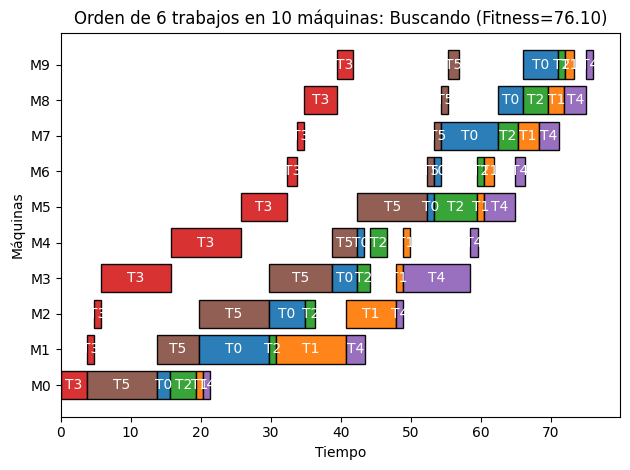

Current solution: [3 5 0 2 1 4] - Associated fitness: 71.97


Iteration... 1
Current solution: [3 2 0 5 1 4] - Associated fitness: 71.73


Iteration... 2


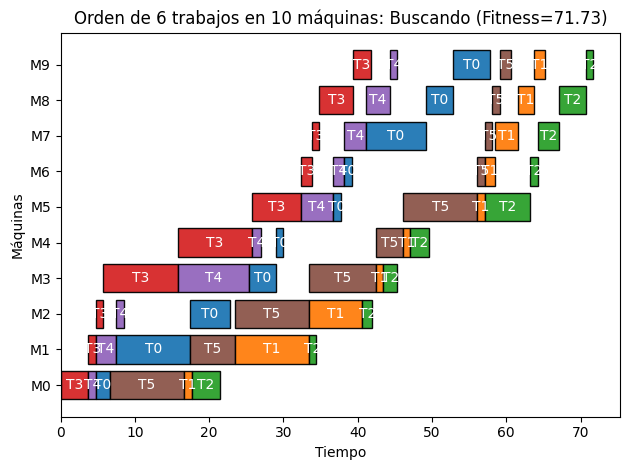

Current solution: [3 4 0 5 1 2] - Associated fitness: 70.87


Iteration... 3
Current solution: [4 3 0 5 1 2] - Associated fitness: 71.73

Solución Óptima: [4 3 0 5 1 2]
Fitness Óptimo: 70.87


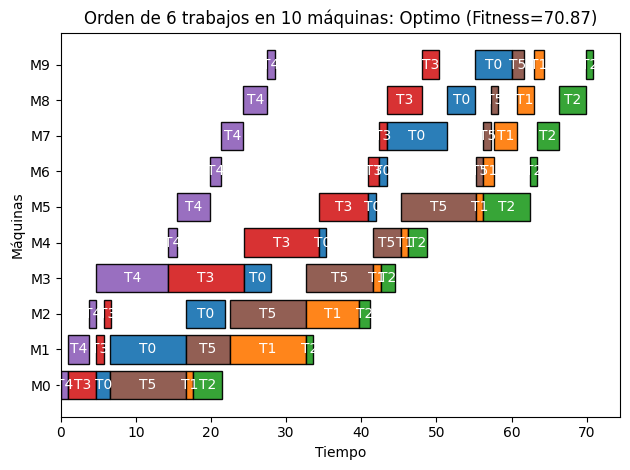

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025  1.         10.
   7.14571817  1.          1.          1.          1.45101492  2.97571132
   2.26214827  1.37689197  3.7854835   1.          1.38206205  1.82510887
   2.43573875  6.15174404  1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337  1.          2.73418891
   1.          9.60169155  1.19783111  4.34502319  1.49418633  2.93644358
   3.16489519  1.         10.          5.96898151 10.          9.00860799
   3.64421765 10.          1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.          5.9179351   1.
   1.          6.75958711  4.90838363  5.22265164  5.9008581   1.
   1.77557069  1.          7.95411829

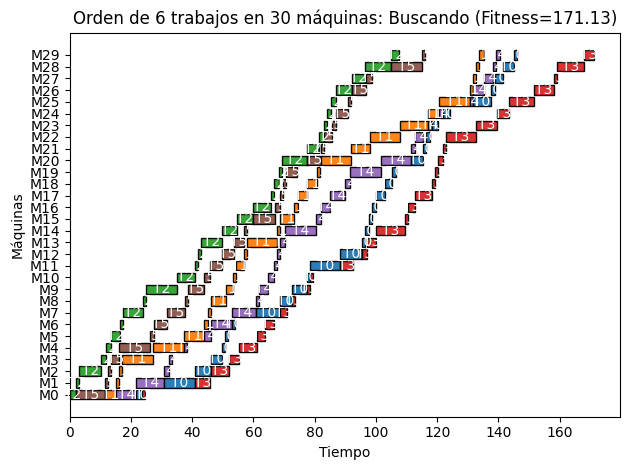

Current solution: [2 5 1 4 0 3] - Associated fitness: 158.20


Iteration... 1
Current solution: [2 3 1 4 0 5] - Associated fitness: 155.95


Iteration... 2


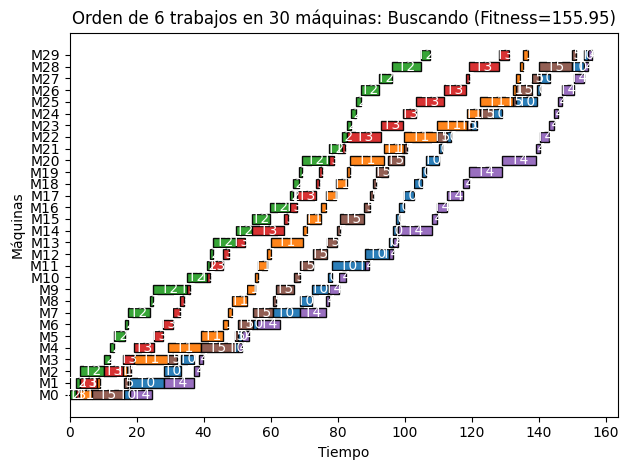

Current solution: [2 3 1 5 0 4] - Associated fitness: 154.31


Iteration... 3
Current solution: [2 3 5 1 0 4] - Associated fitness: 153.93


Iteration... 4


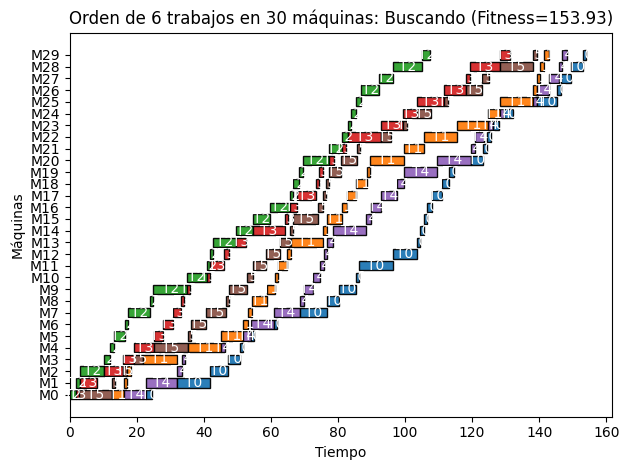

Current solution: [2 3 5 1 4 0] - Associated fitness: 154.31

Solución Óptima: [2 3 5 1 4 0]
Fitness Óptimo: 153.93


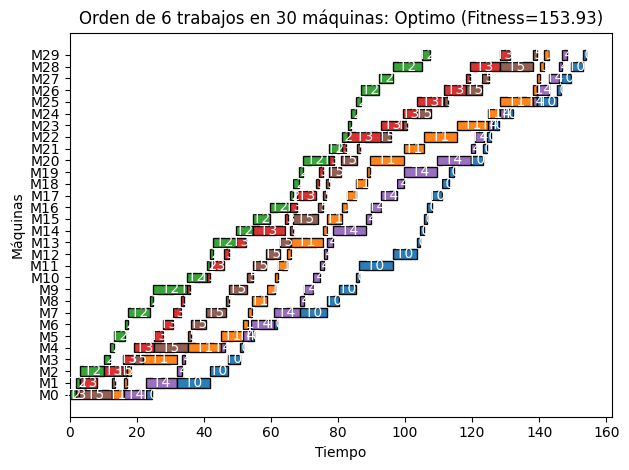

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025  1.         10.
   7.14571817  1.          1.          1.          1.45101492  2.97571132
   2.26214827  1.37689197  3.7854835   1.          1.38206205  1.82510887
   2.43573875  6.15174404  1.          2.88811662  3.59001889  1.
   3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337  1.          2.73418891
   1.          9.60169155  1.19783111  4.34502319  1.49418633  2.93644358
   3.16489519  1.         10.          5.96898151 10.          9.00860799
   3.64421765 10.          1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.          5.9179351   1.
   1.          6.75958711  4.90838363  5.22265164  5.9008581   1.
   1.77557069  1.          7.95411829  3.90520

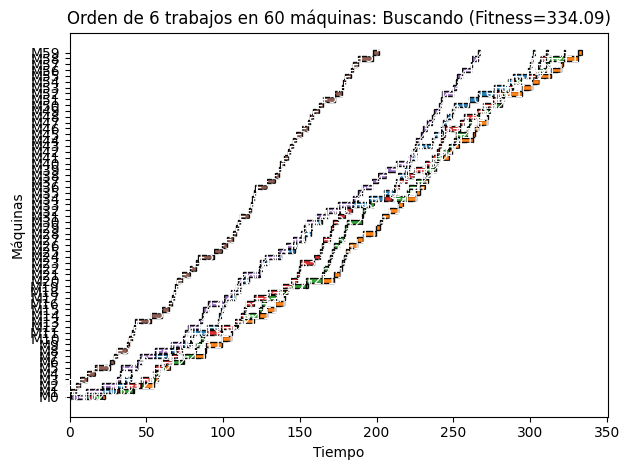

Current solution: [5 4 0 3 2 1] - Associated fitness: 297.86


Iteration... 1
Current solution: [5 1 0 3 2 4] - Associated fitness: 283.29


Iteration... 2


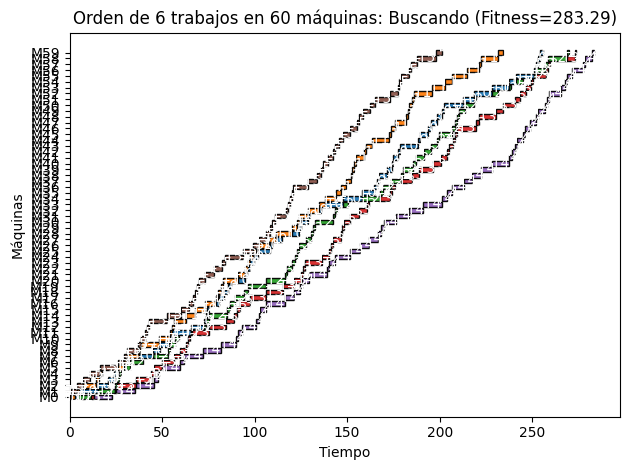

Current solution: [5 1 0 2 3 4] - Associated fitness: 284.26

Solución Óptima: [5 1 0 2 3 4]
Fitness Óptimo: 283.29


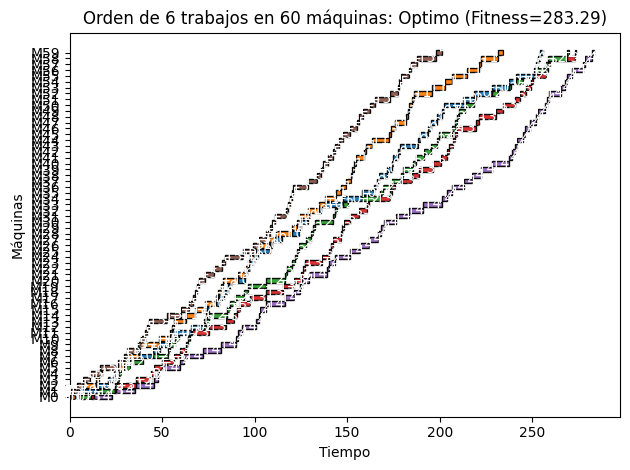

In [71]:
solutions_dict = {}


for number_of_machines in [10,30,60]:
    solucion_optima, fitness_sol = run_flowshop_hill_climbing(
            num_jobs=6,
            num_machines=number_of_machines,
            mean_time=4.0,
            minimo=1.0,
            maximo=10.0,
            plot_interval=2,
            seed=42
        )

    solutions_dict[number_of_machines] = {
        "solucion_optima": solucion_optima,
        "fitness": fitness_sol
    }

In [72]:
solutions_dict

{10: {'solucion_optima': array([4, 3, 0, 5, 1, 2]),
  'fitness': np.float32(70.870094)},
 30: {'solucion_optima': array([2, 3, 5, 1, 4, 0]),
  'fitness': np.float32(153.92546)},
 60: {'solucion_optima': array([5, 1, 0, 2, 3, 4]),
  'fitness': np.float32(283.29227)}}